In [3]:
#imports
import numpy as np
import torch as tr
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import sklearn.svm
from cvxopt.solvers import qp
from cvxopt import matrix as cvxmatrix

In [4]:
# provided stub

class neural_network():
    def __init__(self, layers=[2, 100, 2], scale=.1, p=.1, lr=.1, lam=.1):
        super().__init__()
        self.weights = tr.nn.ParameterList([tr.nn.Parameter(scale * tr.randn(m, n)) for m, n in zip(layers[:-1], layers[1:])])
        self.biases = tr.nn.ParameterList([tr.nn.Parameter(scale * tr.randn(n)) for n in layers[1:]])
        self.parameters = list(self.weights) + list(self.biases)

        self.p = p
        self.lr = lr
        self.lam = lam
        self.train = False

    def relu(self, X, W, b):
        # algorithm 15, pg 46 from guide.pdf
        if self.train:
            delta = bernoulli.rvs(1 - self.p,
                                  size=W.shape[1])  # sample 'out' many samples from Bernoulli distribution B(1-p)
            Z = tr.from_numpy(delta) * tr.max(tr.zeros(X.shape[0], W.shape[1]), tr.mm(X, W) + b)

        else:
            Z = tr.max(tr.zeros(X.shape[0], W.shape[1]), (1 - self.p) * tr.mm(X, W) + b)

        return Z

    def softmax(self, Z, W, b):
        # algorithm 16, pg 46 from guide.pdf
        Z = tr.mm(Z, W) + b
        y_hat = tr.div(tr.exp(Z).T, tr.sum(tr.exp(Z), dim=1)).T

        return y_hat

    def forward(self, X):
        # algorithm 14, pg 45 from guide.pdf
        X = tr.tensor(X, dtype=tr.float)
        Z = X
        # apply ReLU to all layers but the last
        for w, b in zip(self.weights[:len(self.weights) - 1],
                        self.biases[:len(self.biases) - 1]):  # iterate through L-1 layers
            Z = self.relu(Z, w, b)
        # apply softmax to last layer
        y_hat = self.softmax(Z, self.weights[len(self.weights) - 1], self.biases[len(self.biases) - 1])

        return y_hat

    def predict(self, X):
        return self.forward(X).detach().numpy()

    def loss(self, ypred, ytrue):
        # compute cross entropy loss according to pg47 from guide.pdf
        loss = (-1 / ytrue.shape[0]) * tr.sum(ytrue * tr.log(ypred))

        return loss

    def fit(self, X, y, nsteps=1000, bs=100, plot=False):
        X, y = tr.tensor(X), tr.tensor(y)
        optimizer = tr.optim.SGD(self.parameters, lr=self.lr, weight_decay=self.lam)

        I = tr.randperm(X.shape[0])
        n = int(np.ceil(.1 * X.shape[0]))
        Xtrain, ytrain = X[I[:n]], y[I[:n]]
        Xval, yval = X[I[n:]], y[I[n:]]

        Ltrain, Lval, Aval = [], [], []
        for i in range(nsteps):
            optimizer.zero_grad()
            I = tr.randperm(Xtrain.shape[0])[:bs]
            self.train = True
            output = self.loss(self.forward(Xtrain[I]), ytrain[I])
            self.train = False
            Ltrain += [output.item()]
            output.backward()
            optimizer.step()

            outval = self.forward(Xval)
            Lval += [self.loss(outval, yval).item()]
            Aval += [np.array(outval.argmax(-1) == yval.argmax(-1)).mean()]

        if plot:
            plt.plot(range(nsteps), Ltrain, label='Training loss')
            plt.plot(range(nsteps), Lval, label='Validation loss')
            plt.plot(range(nsteps), Aval, label='Validation acc')
            plt.legend()
            plt.show()

In [13]:
#from ps4_tests.py
m = tr.nn.ReLU()
inp = tr.randn(2)
print(inp)
output = m(inp)
print(output)

tensor([-0.1495,  0.5810])
tensor([0.0000, 0.5810])


In [15]:
#from ps4_tests.py

X = tr.tensor([[1, 1], [0, 0]], dtype=tr.float)
y = tr.tensor([[0, 1], [1, 0]], dtype=tr.int)
W = tr.tensor([[1, .2], [.5, 1]], dtype=tr.float)
b = tr.tensor([-1, -1], dtype=tr.float)
#m = neural_network(layers=[2,2,2], p=0, lam=0)

#m.fit(X, y, nsteps=1, bs=1, plot=False)

relu_out = tr.tensor([[.5,.2],[0, 0]])
#self.assertTrue(np.allclose(m.relu(X, W, b), relu_out), msg='neural_network: Error. ReLU output not correct')
print(relu_out)

tensor([[0.5000, 0.2000],
        [0.0000, 0.0000]])


In [16]:
#testing relu
def relu(p, X, W, b):
    # YOUR CODE HERE!
    #algorithm 15, pg 46 from guide.pdf
    if train:
        delta = bernoulli.rvs(1-p, size=W.shape[1]) #sample 'out' many samples from Bernoulli distribution B(1-p) 
        Z = tr.from_numpy(delta) * tr.max(tr.zeros(X.shape[0],W.shape[1]),tr.mm(X,W)+b)
        #Z = delta.detach().numpy() * np.maximum(0,torch.mm(X,W)+b)
        
    else:
        Z = tr.max(tr.zeros(X.shape[0],W.shape[1]),(1-p)*tr.mm(X,W)+b)
            
    return Z

In [17]:
Z = relu(p, X, W, b)
print(Z)

NameError: name 'p' is not defined

In [18]:
print(Z.T)

NameError: name 'Z' is not defined

In [ ]:
#testing softmax
def softmax(Z, W, b):
    # algorithm 16, pg 46 from guide.pdf
    Z = torch.mm(Z,W)+b
    y_hat = torch.div(torch.exp(Z).T,torch.sum(torch.exp(Z),dim=1)).T #can't specify division dim so double transpose to get desired behaviour
    return y_hat

In [ ]:
y_hat = softmax(Z, W, b)

In [ ]:
y_hat

In [6]:
layers = [2,100,2]
scale = .1
weights = torch.nn.ParameterList([torch.nn.Parameter(scale*torch.randn(m, n)) for m, n in zip(layers[:-1], layers[1:])])
biases = torch.nn.ParameterList([torch.nn.Parameter(scale*torch.randn(n)) for n in layers[1:]])

NameError: name 'torch' is not defined

In [7]:
print(weights[:2])

NameError: name 'weights' is not defined

In [8]:
#testing forward
def forward(weights,biases, X):
    # algorithm 14, pg 45 from guide.pdf
    X = torch.tensor(X, dtype=torch.float)
    Z = X
    #apply ReLU to all layers but the last
    for w, b in zip(weights[:len(weights)-1], biases[:len(biases)-1]): #iterate through L-1 layers
        Z = relu(p, Z, w, b)
    #apply softmax to last layer
    y_hat = softmax(Z, weights[len(weights)-1], biases[len(biases)-1])
    
    return y_hat

In [9]:
y_hat=forward(weights,biases,X)

NameError: name 'weights' is not defined

In [10]:
def loss(self, ypred, ytrue):
    # compute cross entropy loss according to pg47 from guide.pdf
    loss = (-1/ytrue.shape[0])*torch.sum(ytrue*torch.log(ypred))
    
    return loss

In [129]:
#Assignment 2

def plot_boundary_2d(X, y, model):
    """
    Plots a 2 dimensional boundary of a model.
    
    Inputs:
    X = 2d data array (nx2) 
    y = labels (nx1)
    model = model (typically SVM or neural net)
    """
    #1. plot points X
    plt.scatter(X.T[0][np.argwhere(y==1)],X.T[1][np.argwhere(y==1)],c='b',label='Positive class')
    plt.scatter(X.T[0][np.argwhere(y==-1)],X.T[1][np.argwhere(y==-1)],c='r',label='Negative class')
    
    #2. mark support vectors with a cross if SVM
    if isinstance(model, svm_sklearn):
        plt.scatter(model.X_sv.T[0],model.X_sv.T[1],s=80,c='y',marker='x',label='Support vectors')
    
    #3. plot separating hyperplane
    #3a. create grid of predictions
    x_max = np.amax(X,axis=0)
    x_min = np.amin(X,axis=0)
    x0 = np.linspace(x_min[0],x_max[0],50)
    x1 = np.linspace(x_min[1],x_max[1],50)
    x0v, x1v = np.meshgrid(x0, x1)
    Xv = np.squeeze(np.array((x0v.reshape(2500,1),x1v.reshape(2500,1))))
    grid_pred = model.predict(Xv.T)
    #3b plot level 0 contour line
    plt.contour(x0,x1,grid_pred.reshape(50,50),levels=0)
    
    #format plot
    plt.ylabel('X1')
    plt.xlabel('X0')
    plt.title('2D visualisation of model classifications with a separating hyperplane')
    plt.legend()
    

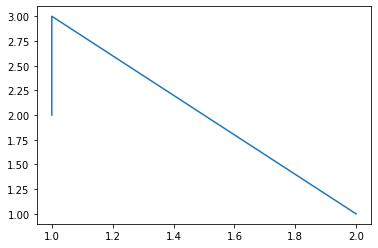

In [67]:
plt.plot(X.T[0],X.T[1])

(3, 2)


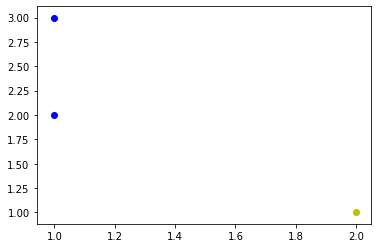

In [52]:
X = np.array([[1,2],[1,3],[2,1]])
y = np.array([1,1,-1])
print(X.shape)
plt.scatter(X.T[0][np.argwhere(y==1)],X.T[1][np.argwhere(y==1)],c='b',label='Positive class')
plt.scatter(X.T[0][np.argwhere(y==-1)],X.T[1][np.argwhere(y==-1)],c='y',label='Negative class')




In [37]:
class svm_sklearn():
    """ SVM via scikit-learn """
    def __init__(self, kernel='linear', kernelparameter=1., C=1.):
        if kernel == 'gaussian':
            kernel = 'rbf'
        self.clf = sklearn.svm.SVC(C=C,
                                   kernel=kernel,
                                   gamma=1./(1./2. * kernelparameter ** 2),
                                   degree=kernelparameter,
                                   coef0=kernelparameter)

    def fit(self, X, y):
        self.clf.fit(X, y)
        self.X_sv = X[self.clf.support_, :]
        self.y_sv = y[self.clf.support_]

    def predict(self, X):
        return self.clf.decision_function(X)

In [57]:
class neural_network():
    def __init__(self, layers=[2, 100, 2], scale=.1, p=.1, lr=.1, lam=.1):
        super().__init__()
        self.weights = tr.nn.ParameterList([tr.nn.Parameter(scale * tr.randn(m, n)) for m, n in zip(layers[:-1], layers[1:])])
        self.biases = tr.nn.ParameterList([tr.nn.Parameter(scale * tr.randn(n)) for n in layers[1:]])
        self.parameters = list(self.weights) + list(self.biases)

        self.p = p
        self.lr = lr
        self.lam = lam
        self.train = False

    def relu(self, X, W, b):
        # algorithm 15, pg 46 from guide.pdf
        if self.train:
            delta = bernoulli.rvs(1 - self.p,
                                  size=W.shape[1])  # sample 'out' many samples from Bernoulli distribution B(1-p)
            Z = tr.from_numpy(delta) * tr.max(tr.zeros(X.shape[0], W.shape[1]), tr.mm(X, W) + b)

        else:
            Z = tr.max(tr.zeros(X.shape[0], W.shape[1]), (1 - self.p) * tr.mm(X, W) + b)

        return Z

    def softmax(self, Z, W, b):
        # algorithm 16, pg 46 from guide.pdf
        Z = tr.mm(Z, W) + b
        y_hat = tr.div(tr.exp(Z).T, tr.sum(tr.exp(Z), dim=1)).T

        return y_hat

    def forward(self, X):
        # algorithm 14, pg 45 from guide.pdf
        X = tr.tensor(X, dtype=tr.float)
        Z = X
        # apply ReLU to all layers but the last
        for w, b in zip(self.weights[:len(self.weights) - 1],
                        self.biases[:len(self.biases) - 1]):  # iterate through L-1 layers
            Z = self.relu(Z, w, b)
        # apply softmax to last layer
        y_hat = self.softmax(Z, self.weights[len(self.weights) - 1], self.biases[len(self.biases) - 1])

        return y_hat

    def predict(self, X):
        return self.forward(X).detach().numpy()

    def loss(self, ypred, ytrue):
        # compute cross entropy loss according to pg47 from guide.pdf
        loss = (-1 / ytrue.shape[0]) * tr.sum(ytrue * tr.log(ypred))

        return loss

    def fit(self, X, y, nsteps=1000, bs=100, plot=False):
        X, y = tr.tensor(X), tr.tensor(y)
        optimizer = tr.optim.SGD(self.parameters, lr=self.lr, weight_decay=self.lam)

        I = tr.randperm(X.shape[0])
        n = int(np.ceil(.1 * X.shape[0]))
        Xtrain, ytrain = X[I[:n]], y[I[:n]]
        Xval, yval = X[I[n:]], y[I[n:]]

        Ltrain, Lval, Aval = [], [], []
        for i in range(nsteps):
            optimizer.zero_grad()
            I = tr.randperm(Xtrain.shape[0])[:bs]
            self.train = True
            output = self.loss(self.forward(Xtrain[I]), ytrain[I])
            self.train = False
            Ltrain += [output.item()]
            output.backward()
            optimizer.step()

            outval = self.forward(Xval)
            Lval += [self.loss(outval, yval).item()]
            Aval += [np.array(outval.argmax(-1) == yval.argmax(-1)).mean()]

        if plot:
            plt.plot(range(nsteps), Ltrain, label='Training loss')
            plt.plot(range(nsteps), Lval, label='Validation loss')
            plt.plot(range(nsteps), Aval, label='Validation acc')
            plt.legend()
            plt.show()

(2, 2500)
(2500, 1)
[[-0.         -0.02040816 -0.04081633 ... -0.95918367 -0.97959184
  -1.        ]
 [ 0.04081633  0.02040816 -0.         ... -0.91836735 -0.93877551
  -0.95918367]
 [ 0.08163265  0.06122449  0.04081633 ... -0.87755102 -0.89795918
  -0.91836735]
 ...
 [ 1.91836735  1.89795918  1.87755102 ...  0.95918367  0.93877551
   0.91836735]
 [ 1.95918367  1.93877551  1.91836735 ...  1.          0.97959184
   0.95918367]
 [ 2.          1.97959184  1.95918367 ...  1.04081633  1.02040816
   1.        ]]
(2, 2500)
[[1.         1.02040816 1.04081633 ... 1.95918367 1.97959184 2.        ]
 [1.         1.         1.         ... 3.         3.         3.        ]]


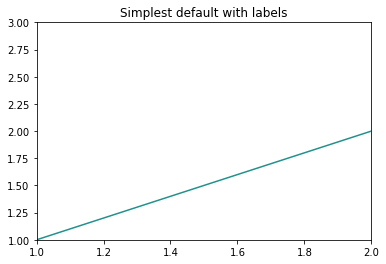

In [126]:
model = svm_sklearn()
model.fit(X,y)

#model = neural_network()
#model.fit(X,y)

x_max = np.amax(X,axis=0)
x_min = np.amin(X,axis=0)

x0 = np.linspace(x_min[0],x_max[0],50)
x1 = np.linspace(x_min[1],x_max[1],50)

x0v, x1v = np.meshgrid(x0, x1)
Xv = np.squeeze(np.array((x0v.reshape(2500,1),x1v.reshape(2500,1))))
print(Xv.shape)

grid_pred = model.predict(Xv.T)
print(np.vstack(grid_pred).shape)
print(grid_pred.reshape(50,50))

#plt.contour(x0,x1,grid_pred.reshape(50,50))
#plt.clabel()

fig, ax = plt.subplots()
CS = ax.contour(x0,x1,grid_pred.reshape(50,50),levels=0)
ax.set_title('Simplest default with labels')

print((np.squeeze(Xv).shape))
print(np.squeeze(Xv))


C:\Users\Boris\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: The following kwargs were not used by contour: 'label'


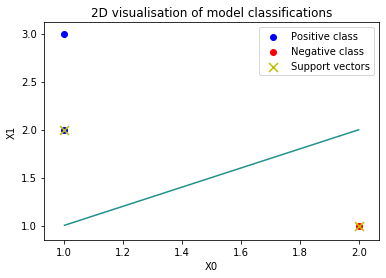

In [130]:
plot_boundary_2d(X,y,model)

In [74]:
svm_sklearn()